# Stock Sector prediction using XGBoost
PCA provides a low dimensional representation of the correlations between price changes in stock.
As was explained in the previous notebook, these correlations correspond to the fact that the prices of similar stocks react similarly to news about changes in the market environment.

In this notebook you will use boosted trees to predict the sector of test stocks. You will use as features the the coefficients of the 20 top eigenvectors as a representation of the stock.

You will not know whether your predicions are correct. However, by splitting the training set into a smaller training set and a validation set, you would be able to estimate the error that your classifier will incur on the test set.

In [1]:
import pickle
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Read PCA parameters

In [2]:
D=pickle.load(open('data/PCA_true.pickle','rb'))
col=D['columns']
eigvec=D['eigvec']
eigval=D['eigval']

### Sanity check
The following scatterplot should be very similar to the scatter plot you produced in the first notebook for eigvec 1, eigvec 2 (indexing starts with 1)

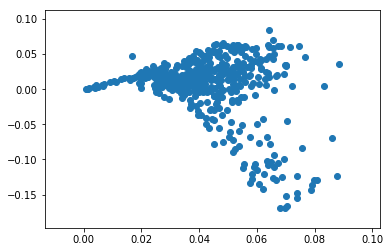

In [3]:
# My Code
scatter(eigvec[:,0],eigvec[:,1])

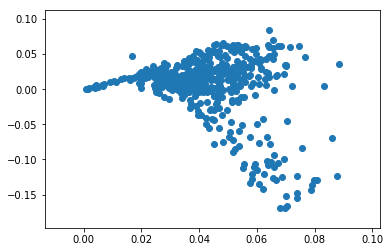

In [3]:
scatter(eigvec[:,0],eigvec[:,1])

## compute features

The features that we use are the coefficients of the top 20 eigenvectors.

Those can be read directly from the eigenvectors matrix.

In [4]:
#Taking the top 20 features(Eigen vectors)
features=eigvec[:,:20]
features.shape

(481, 20)

##  Compute labels (sectors)

In [5]:
TickerInfo=pd.read_csv('data/tickerInfo.tsv',sep='\t')
print(TickerInfo.shape)
TickerInfo.head()

(505, 5)


,Unnamed: 0,Ticker,Name,Sector,SECTOR_ID
0,0,MMM,3M|3M Company,Industrials,INDS
1,1,ABT,Abbott Laboratories,Health Care,HC
2,2,ABBV,AbbVie Inc.,Health Care,HC
3,3,ACN,Accenture plc,Information Technology,IT
4,4,ATVI,Activision Blizzard,Information Technology,IT


### Reading Dictionaries
XGBoost, when used for multi-class classification, requires the labels to be integers.

We therefore provide dictionaries that map between sector name, Sector ID and numbers.


In [6]:
Sectors={'Consumer Discretionary':'CD',
 'Consumer Staples':'CS',
 'Energy':'EN',
 'Financials':'FIN',
 'Health Care':'HC',
 'Industrials':'INDS',
 'Information Technology':'IT',
 'Materials':'MAT',
 'Real Estate':'RE',
 'Telecommunication Services':'TS',
 'Utilities':'UTIL'}


In [7]:
sector2number={'CD': 0,
 'CS': 1,
 'EN': 2,
 'FIN': 3,
 'HC': 4,
 'INDS': 5,
 'IT': 6,
 'MAT': 7,
 'RE': 8,
 'TS': 9,
 'UTIL': 10}

In [8]:
number2sectorName=\
{0: 'Consumer Discretionary',
 1: 'Consumer Staples',
 2: 'Energy',
 3: 'Financials',
 4: 'Health Care',
 5: 'Industrials',
 6: 'Information Technology',
 7: 'Materials',
 8: 'Real Estate',
 9: 'Telecommunication Services',
 10: 'Utilities'}

### Construct the training and testing datasets

In [9]:
labels=[]
feature_vectors=[]
feature_vectors_test=[]
test_nos = []
for i in range(len(col)):
    c=col[i]
    if 'train' in c:
        ticker=c[6:-2]
        answer=list(TickerInfo[TickerInfo.Ticker==ticker]['SECTOR_ID'])
        if len(answer)==1:
            sector_no=sector2number[answer[0]]
            labels.append(sector_no)
            feature_vectors.append(features[i,:])
        else:
            print('error: could not find sector for ticker:',ticker)
    if 'test' in c:
        test_nos.append(c[5:-2])
        feature_vectors_test.append(features[i,:])

In [10]:
#verify lengths
len(labels),len(feature_vectors), len(test_nos),len(feature_vectors_test)

(392, 392, 89, 89)

## Placing the data into numpy arrays as expected by xgboost

In [11]:
X=np.array(feature_vectors)
y=np.array(labels)
X_test = np.array(feature_vectors_test)
X.shape, y.shape, X_test.shape

((392, 20), (392,), (89, 20))

In [12]:
#Splitting the labeled data (X,y) into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=6)
X_train.shape, X_valid.shape

((274, 20), (118, 20))

In [13]:
#Parameters
param = {}
param['max_depth']= 3   # depth of tree
param['eta'] = 0.3      # shrinkage parameter
param['silent'] = 1     # not silent
param['objective'] = 'multi:softmax'
param['nthread'] = 7 # Number of threads used
param['num_class']=11

num_round = 100

## Generating scores using XGBoost

The function <font color="blue">get_margin_scores</font> is used to predict the sector for each of the given samples.

**<font color="magenta" size=2>Input</font>**
<br>
1. **Training set** (X_train)
2. **Validation set** (X_valid)
3. **Training labels** (y_train)
4. **XGBoost Parameter List** (param)


**<font color="blue" size=2>Output</font>**
<br>
Return the following:
1. **y_pred_valid**: The raw output scores for the validation set


**Note**:
1. Round all raw scores to **three** decimal places
2. Remember to use **verbose_eval = False** while training.
3. Remember to provide the **num_round** parameter while training and do not change it. We have currently set it to 100 (Refer to previous cell). Not providing the parameter or changing it could produce different results.
4. Documentation for XGBoost Python API is [here](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

**All but one of the lines of the function have been filled. You need only fill the one missing line that trains the model. Check the XGBoost documentation for instructions on using train() function for XGBoost**

In [15]:
def get_margin_scores(X_train, X_valid, y_train, param):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    evallist = [(dtrain, 'train')]
    plst = param.items()
    #
    # YOUR CODE HERE
    #
    bst = xgb.train(plst, dtrain, num_round, evallist, verbose_eval=False)
    dvalid = xgb.DMatrix(X_valid)
    y_pred_valid = bst.predict(dvalid, ntree_limit=bst.best_ntree_limit, output_margin=True)
    y_pred_valid = np.around(y_pred_valid, decimals = 3)
    return y_pred_valid


In [47]:
y_pred_valid = get_margin_scores(X_train, X_valid, y_train, param)

In [48]:
assert y_pred_valid.shape == (118, 11), "Incorrect shape"
assert type(y_pred_valid) == numpy.ndarray, "Incorrect type"

In [49]:
# Hidden Tests Here
#If rounding off is the problem, give them 6 points out of 8
#
# AUTOGRADER TEST - DO NOT REMOVE
#
y_pred_valid


array([[-0.347, -3.01 , -1.557, ...,  6.04 , -3.06 , -2.764],
       [ 0.274, -1.584, -2.223, ..., -1.715, -2.847, -2.764],
       [-3.213, -0.942, -1.678, ..., -3.222, -2.962, -2.764],
       ...,
       [-3.061, -0.613, -3.024, ..., -3.198, -2.749, -2.764],
       [ 0.077, -2.768, -1.557, ..., -1.563, -3.06 , -2.764],
       [-3.263, -1.683, -2.316, ..., -2.117, -2.847, -2.764]],
      dtype=float32)

In [19]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [20]:
#
# AUTOGRADER TEST - DO NOT REMOVE
#


## Computing Top1 and Top5 predictions

Using the margin scores generated, calculate the top1 and top5 predictions for the given data:

**top1**: Find the highest scoring prediction for each example in the validation set

**top5**: Find the top 5 highest scoring predictions in descending order for each example in the validation set (Highest to lowest)

**<font color="magenta" size=2>Input</font>**

1. **Validation Output Scores** (y_pred_valid)

**<font color="blue" size=2>Output</font>**

1. **predictions_valid**: The index for highest scoring prediction for each example in the the validation set
2. **predictions_topn**: The indices for the top 5 highest scoring prodictions for each example in the validation set

**<font color="magenta" size=2>Sample input</font>**
1. **y_pred_valid**: [[-0.3, 1.2, 0.3, 0.5, -0.4, 0.0, 0.01, 1.0, -1.3, 0.2, -1.2], [0.4, -0.5, 1.3, -0.2, 0.6, -2.2, -0.8, 1.9, 0.9, -0.2, -1.7]]

**<font color="blue" size=2>Sample output</font>** 
1. **predictions_valid**: [1, 7]
2. **predictions_top5**: [[1,  7,  3,  2,  9], [ 7,  2,  8,  4,  0]]

In [45]:
def get_predictions(y_pred_valid):
    #
    # YOUR CODE HERE
    #
   
    predictions_valid = np.argmax(y_pred_valid, axis=1)
    predictions_top5 = np.argsort(y_pred_valid)[:,-5:][:,::-1]
    return predictions_valid, predictions_top5
    


In [46]:
y_pred_valid_test = [[-0.3, 1.2, 0.3, 0.5, -0.4, 0.0, 0.01, 1.0, -1.3, 0.2, -1.2], [0.4, -0.5, 1.3, -0.2, 0.6, -2.2, -0.8, 1.9, 0.9, -0.2, -1.7]]
predictions_valid, predictions_top5 = get_predictions(y_pred_valid_test)
print(predictions_valid)
print(predictions_top5)

[1 7]
[[1 7 3 2 9]
 [7 2 8 4 0]]


In [50]:
predictions_valid, predictions_top5 = get_predictions(y_pred_valid)

In [51]:
assert predictions_valid.shape == (118,), "Incorrect shape"
assert predictions_top5.shape == (118, 5), "Incorrect shape"
assert type(predictions_valid) == numpy.ndarray, "Incorrect type"
assert type(predictions_top5) == numpy.ndarray, "Incorrect type"

In [52]:
# Check if you get the correct top4 for the first 3 elements.
predictions_top5_first3=\
    array([[8, 3, 0, 6, 2],
           [6, 0, 7, 1, 8],
           [3, 7, 1, 5, 2]])
assert (predictions_top5_first3 == predictions_top5[:3]).all(), "Incorrect predictions"

In [24]:
# Hidden Tests Here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [25]:
# Hidden Tests Here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


## Estimating accuracy
We will now compute the accuracies of the predictions, where
* **Top 1** is the fraction of examples on which the correct sector has the highest score.
* **Top 2** is the fraction of examples on which the correct sector has the highest **or** the second highest score.
* ...
* **Top 5** is the fraction of examples on which the correct sector has one of the top 5 scores.

These scores are all based on the training set. In principle, the errors on the test set can be different. However, if we assume that the test set and the train set are generated by the same distribution, then these are reasonable estimates of the accuracies that we expect to get.

In [53]:
acc = 0
for i in range(5):
    acc += sum(predictions_top5[:, i]==y_valid)
    print("Top ", i+1, ": \t", acc/len(y_valid))

Top  1 : 	 0.7203389830508474
Top  2 : 	 0.864406779661017
Top  3 : 	 0.9152542372881356
Top  4 : 	 0.9322033898305084
Top  5 : 	 0.9491525423728814


## Generating the confusion matrix

What is a confusion matrix?
This is a useful link that explains this: https://en.wikipedia.org/wiki/Confusion_matrix#Example

We will now be using the top 2 values of **predictions_top5** to produce the confusion matrix. We will create the confusion matrix by considering the correct section $j$ and the two sections with the two highest scores $i_1,i_2$ where $score(i_1) > score(i_2)$.

* A prediction is *correct* if $j=i_1$. correct examples are ignored.
* The predicion $i_2$ is confused with $i_1$ if $j=i_2$
* If $j \neq i_1$ and $j \neq i_2$ then the example is ignored. 

### Examples

We consider two scenarios where the possible categories are `(0,1,2,3)`

#### Scenario 1

**<font color="magenta" size=2>Sample Input</font>**<br>
y_label = 3<br>
top2_predictions = [2, 3]

**<font color="blue" size=2>Output</font>**<br>
confusion_matrix:<br>
[0 0 0 0]<br>
[0 0 0 0]<br>
[0 0 0 1]<br>
[0 0 0 0]<br>
**Explanation**:  
The first example has top two predictions: (2, 3) and the label 3. So we add 1 to the position (2,3).

#### Scenario 2

**<font color="magenta" size=2>Sample Input</font>**<br>
Say we have 7 sample prediction values<br>
y_label = [3, 2, 3, 1, 0, 2, 2]<br>
top2_predictions = [[2, 3], [0, 3], [2, 3], [1, 2], [3, 0], [2, 0], [3, 2]]

**<font color="blue" size=2>Output</font>**<br>
confusion_matrix:<br>
[0 0 0 0]<br>
[0 0 0 0]<br>
[0 0 0 2]<br>
[1 0 1 0]<br>

**Explanation**:  
The second example has 7 sample predictions: 
1. In two scenarios 2 is predicted in place of 3 and the cell (2,3) is incremented twice.
2. In two other scenarios we have a case where the second prediction is right. The corresponding cells {(3,0) and (3,2)} are incremented once each.
3. In two scenarios, the first element is the correct prediction. Thus no cell is incremented.
4. In one scenario, neither of the top 2 predictions is correct. Thus no cell is incremented.

**Note**: y_label is the same as y_valid here.

**All but one of the lines of the function have been filled. You need only fill the one missing line that updates the confusion matrix if a confusion (i.e., sector that should be labeled top but is predicted second) happenes during a cycle**

In [54]:
def get_confusion_matrix(predictions_top5, y_valid):
    confusion_matrix = np.zeros((11,11), dtype=int64)
    i=0
    for entry in predictions_top5[:, :2]:
        if entry[1] == y_valid[i]:
            # update confusion_matrix
            #
            # YOUR CODE HERE
            #
            confusion_matrix[entry[0],y_valid[i]] += 1
        i += 1
    return confusion_matrix


In [55]:
confusion_matrix = get_confusion_matrix(predictions_top5, y_valid)

In [56]:
assert confusion_matrix.shape == (11, 11), "Incorrect shape"
assert type(confusion_matrix) == numpy.ndarray, "Incorrect type"
assert type(confusion_matrix[0][0]) == numpy.int64, "Incorrect type"

In [57]:
# Hidden Tests Here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [58]:
for i in range(confusion_matrix.shape[0]):
    print("%30s" % number2sectorName[i], "\t", confusion_matrix[i, :])

        Consumer Discretionary 	 [0 1 0 0 0 0 1 0 0 0 0]
              Consumer Staples 	 [0 0 0 0 0 0 0 0 0 0 0]
                        Energy 	 [0 0 0 0 0 0 0 0 0 0 0]
                    Financials 	 [0 0 0 0 0 0 1 0 0 0 0]
                   Health Care 	 [0 0 0 0 0 0 2 0 0 0 0]
                   Industrials 	 [2 0 0 0 0 0 1 4 0 0 0]
        Information Technology 	 [2 0 0 0 0 0 0 0 0 0 0]
                     Materials 	 [0 0 0 0 0 1 0 0 0 0 0]
                   Real Estate 	 [1 0 0 0 1 0 0 0 0 0 0]
    Telecommunication Services 	 [0 0 0 0 0 0 0 0 0 0 0]
                     Utilities 	 [0 0 0 0 0 0 0 0 0 0 0]


## Interpretation of confusion matrix

Based on the confusion matrix generated, answer the following questions.

Categories:
```
    0) Consumer Discretionary
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

### instructions for answering the questions in this section
1. Each question has two parts: **ans** and **num_scen**
    1. **ans**: A list with numbers corresponding to the different categories. For example, if the answer is Consumer Discretionary and Consumer Staples, the **ans** should be a **list** containing **single tuple**,i.e. `ans=[(0,1)]` 
    2. **num_scen**: Number of scenarios where the condition in the given question is applicable. For example, if the condition given in the question happens 5 times, the **num_scen** should return **5** as an integer, i.e. `num_scen=5`
2. Type checks have been provided to validate the type of your answer
3. Remember that just the answer for the given matrix should be enough, like the example below. **You do not have to write a generic function that answers the question for all confusion matrices.**

Examples:
```python
def example_question():
    ans = [(0,1),(2,3)] # sect 0 is confused with sect 1 and sect 2 is confused with sect 3
    num_scen=4 # each of the elements in each pair is confused with the other 4 times.
    return ans,num_scen
```


### Question 1

Which two sectors are most often confused with each other and how many times? 

```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```


In [59]:
def question_1():
    #
    # YOUR CODE HERE
    #
    ans1 = [(5,7)]
    num_scen1 = 4
    return ans1, num_scen1 

In [60]:
ans1, num_scen1 = question_1()
assert type(ans1) == list, "Incorrect type"
assert type(ans1[0]) == tuple, "Incorrect type"
assert type(ans1[0][0]) == int, "Incorrect type"
assert type(num_scen1) == int, "Incorrect type"

In [34]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [35]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### Question 2
We call a sector `s` "diffuse" if it is common for an example whose correct label is `s` to have another sector get the highest score while `s` gets the second to largest score. In other words, find the sector(s) that has/have the highest score but get(s) predicted as the second place for the most number of time. Also return the number of times that this happened for these sectors.

Which sectors `s` are the most diffuse? For how many examples does diffusion happen?

```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

**Format of answer**

Your answer should have the following format:
```python
def question_2():
    ans2 = <list of numbers>
    num_scen2= <int>
    return ans2,num_scen2
```


In [63]:
def question_2():
    #
    # YOUR CODE HERE
    #
    ans2 = [0,6,7]
    num_scen2 = 7
    return ans2, num_scen2 

In [64]:
ans2, num_scen2 = question_2()
assert type(ans2) == list, "Incorrect type"
assert type(ans2[0]) == int, "Incorrect type"
assert type(num_scen2) == int, "Incorrect type"

In [38]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [39]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### Note for question 3 and 4
**Note**: Ideally, the next two questions require you to generate a different confusion matrix. Instead of relying on the matrix above, you should write your own code to find the answers to the questions. You don't have to create another confusion matrix though, if you think carefully about the relation between the **top predicted sector** and **the labeled sector**. See specific hint below.


### Question 3

Which category/categories is/are never identified? In other words, which category/categories are never predicted as the top prediction?
```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

**Hint: create an array that records the number of times each sector is predicted as the top prediction, then find the minimum values.**

**Format of answer**

Your answer should have the following format:
```python
def question_3():
    ans3 = <list of numbers>
    return ans3
```

**Note: num_scen3 is not required to be returned for this question, only ans3 is needed**

In [80]:
def question_3():
    #
    # YOUR CODE HERE
    #
    array = [sum(i[i!=0]) for i in confusion_matrix[:,]]
    ans3 = [i for i in range(len(array)) if array[i] == 0]
    
    return ans3

In [81]:
ans3 = question_3()
assert type(ans3) == list, "Incorrect type"
assert type(ans3[0]) == int, "Incorrect type"

In [82]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


### Question 4

Which sector(s) is/are most often missed while classifying? In other words, find the sector for which there is the largest number of examples such that the correct label does not appear as the top prediction.


```
    0) Consumer Discretionary  
    1) Consumer Staples  
    2) Energy  
    3) Financials
    4) Health Care   
    5) Industrials   
    6) Information Technology   
    7) Materials   
    8) Real Estate   
    9) Telecommunication Services   
    10) Utilities  
```

**Hint: create an array that records the number of times that a labeled sector is not predicted as the top prediction, then located the largest values.**

**Format of answer**

Your answer should have the following format:
```python
def question_4():
    ans4 = <list of numbers>
    num_scen4= <int>
    return ans4,num_scen4
```

In [98]:
def question_4():
    #
    # YOUR CODE HERE
    #
    array = np.array([len(i[i!=0]) for i in confusion_matrix])
    ans4 = [np.argmax(array)]
    num_scen4 = int(np.max(array))
    
    return ans4, num_scen4 

In [99]:
ans4, num_scen4 = question_4()
assert type(ans4) == list, "Incorrect type"
assert type(num_scen4) == int, "Incorrect type"

In [45]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


In [46]:
# Hidden tests here
#
# AUTOGRADER TEST - DO NOT REMOVE
#


80 points